# В файле описан процесс обучения и предсказания объектов, также описана архитектура U-Net и вывод графиков

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model
from PIL import Image
import numpy as np
from keras.metrics import IoU
import matplotlib.pyplot as plt
from load_images import pipeline_load_images, display
from keras import backend as K

In [ ]:
def double_conv_block(x, n_filters):
    """
    Функция создает двойной сверточный блок.
    
    params:
    :param x (tensor): Входной тензор.
    :param n_filters (int): Количество фильтров для сверточных слоев.
    :return x: Выходной тензор после применения двух сверточных слоев.
    """
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

In [ ]:
def downsample_block(x, n_filters):
    """
    Функция добавляет к двойному сверточному блоку пулинг и регуляризацию. (слои encoder)
    
    params:
    :param x (tensor): Входной тензор.
    :param n_filters (int): Количество фильтров для сверточных слоев.
    :return f: Выходной тензор после применения двух сверточных слоев.
    :return p: два сверточных слоя + пулинг  и регуляризация
    """
    f = double_conv_block(x, n_filters)
    p = MaxPool2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    """
    Функция decoder, повышающие слои

    x (tensor): Входной тензор из предыдущего слоя декодера.
    conv_features (tensor): Тензор признаков с соответствующего уровня энкодера для skip-connection.
    n_filters (int): Количество фильтров для сверточных слоев.
    :return x(tensor): Выходной тензор после повышающего семплинга, конкатенации и свертки.
    """
    x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = Concatenate()([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def unet_model(input_shapes=(128, 128, 3)):
    """
    Основная архитектура U-Net.

    input_shapes: размер входного изображения
    """
    # input
    inputs = Input(shape=input_shapes)

    # encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # мост
    bottleneck = double_conv_block(p4, 1024)

    # decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Выходной слой
    outputs = Conv2D(3, 1, padding="same", activation="softmax")(u9)

    unet_model = Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
def plot_learning_curve(history):
    """
    Функция к построению графиков метрики accuracy + loss для train и validation выборки
    
    """
    # Извлекаем данные о точности и потерях
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Построение графика точности
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Построение графика потерь
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_predictions(model, test_batches, num_samples=3):
    """
    Функция предикта изображений
    
    """
    
    # Получаем один батч из test_batches
    test_samples = next(iter(test_batches.take(1)))
    
    images, masks = test_samples
    
    # Получаем предсказания модели
    predictions = model.predict(images)
    
    # Преобразуем предсказания в маски
    predicted_masks = tf.argmax(predictions, axis=-1)
    
    # Ограничиваем количество отображаемых изображений до num_samples
    num_to_display = min(num_samples, images.shape[0])
    
    # Отображаем результаты для выбранного количества изображений
    for i in range(num_to_display):
        plt.figure(figsize=(15, 5))
        
        # Отображаем исходное изображение
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # Отображаем истинную маску
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i, ..., 0])
        plt.title('True Mask')
        plt.axis('off')
        
        # Отображаем предсказанную маску
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i])
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


In [ ]:
def fit_compile_predict():
    input_shape = (128, 128, 3)
    model = unet_model(input_shape)
    #print(model.summary())
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    train_batches, validation_batches, test_batches, steps_per_epoch, validation_steps = pipeline_load_images()

    num_epochs = 30
    model_history = model.fit(train_batches,
                              epochs=num_epochs,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_batches,
                              validation_steps=validation_steps)
    # Вызов функции после обучения
    plot_learning_curve(model_history)
    return model_history, test_batches
    # Проверка на test датасете

In [ ]:
model_history, test_batches = fit_compile_predict()

#### После обучения модели, accuracy = 0.8147 на трейне и 0.8156 на валидационной выборке. Достаточно хороший результат после 30 эпох

#### Ниже показан график обучения, по нему можно понять, что расхождения между ними нет, т.е. переобучения не произошло

In [ ]:
plot_learning_curve(model_history)

#### Вывел несколько тестовых изображений, которые в целом удовлетворительно определяют сегментацию объектов

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 186s 18s/step - accuracy: 0.5255 - loss: 1.0912 - val_accuracy: 0.6278 - val_loss: 0.9039
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 184s 19s/step - accuracy: 0.5868 - loss: 0.9456 - val_accuracy: 0.6113 - val_loss: 0.8919
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 188s 19s/step - accuracy: 0.5918 - loss: 0.8937 - val_accuracy: 0.6189 - val_loss: 0.8596
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 199s 20s/step - accuracy: 0.5957 - loss: 0.8740 - val_accuracy: 0.6301 - val_loss: 0.8702
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 203s 20s/step - accuracy: 0.5912 - loss: 0.8765 - val_accuracy: 0.6278 - val_loss: 0.8013
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 209s 21s/step - accuracy: 0.6153 - loss: 0.8138 - val_accuracy: 0.6173 - val_loss: 0.7719
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 224s 23s/step - accuracy: 0.6242 - loss: 0.8064 - val_accuracy: 0.6947 - val_loss: 0.7238
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 213s 21s/step - accuracy: 0.6785 - loss: 0.7419 - val_accuracy: 0.

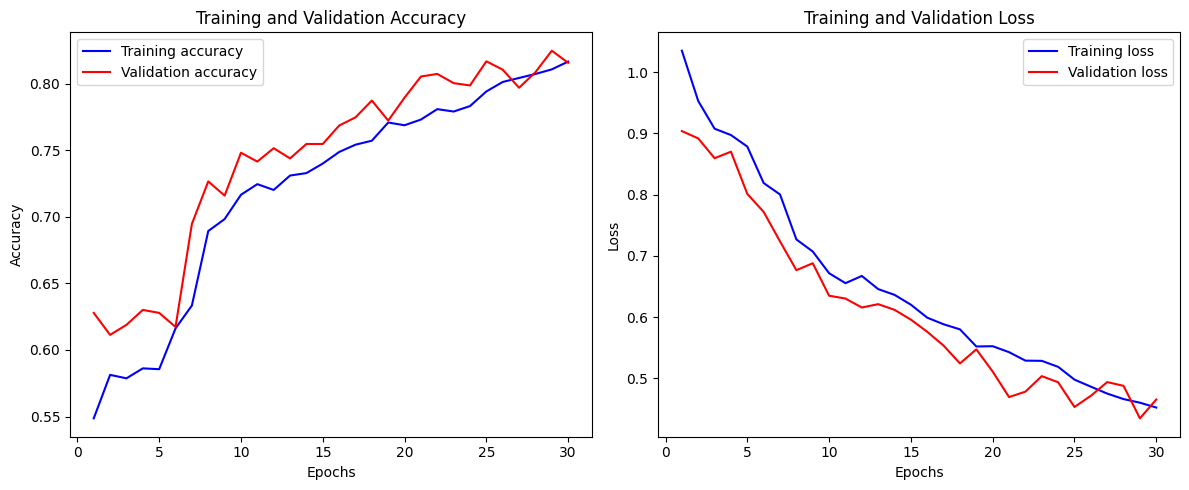

In [15]:
model_history, test_batches = fit_compile_predict()

#### После обучения модели, accuracy = 0.8147 на трейне и 0.8156 на валидационной выборке. Достаточно хороший результат после 30 эпох

#### Ниже показан график обучения, по нему можно понять, что расхождения между ними нет, т.е. переобучения не произошло

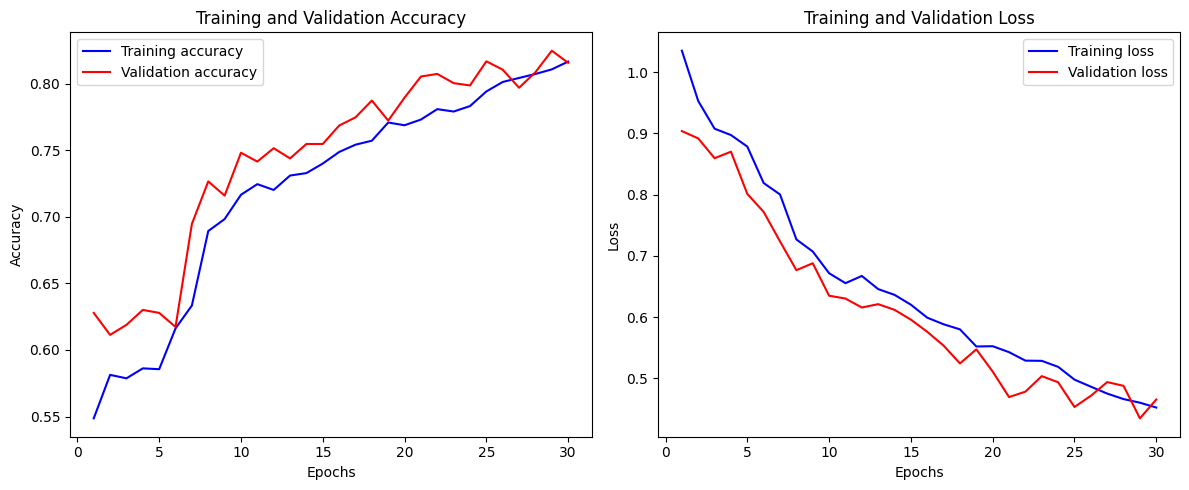

In [22]:
plot_learning_curve(model_history)

#### Вывел несколько тестовых изображений, которые в целом удовлетворительно определяют сегментацию объектов

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


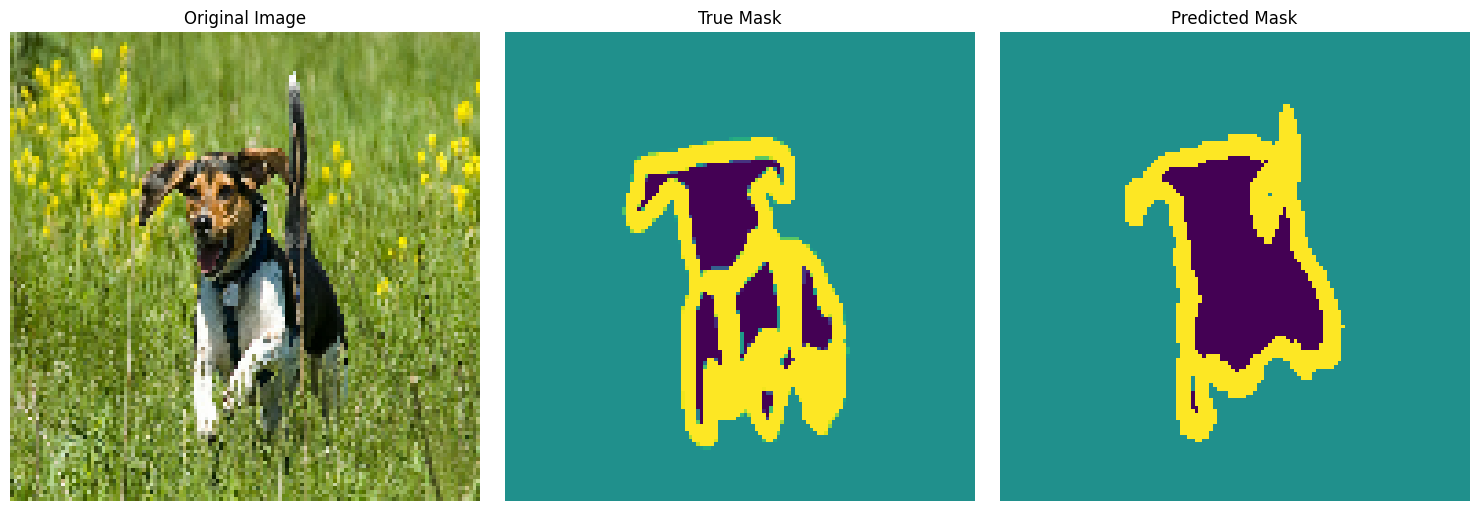

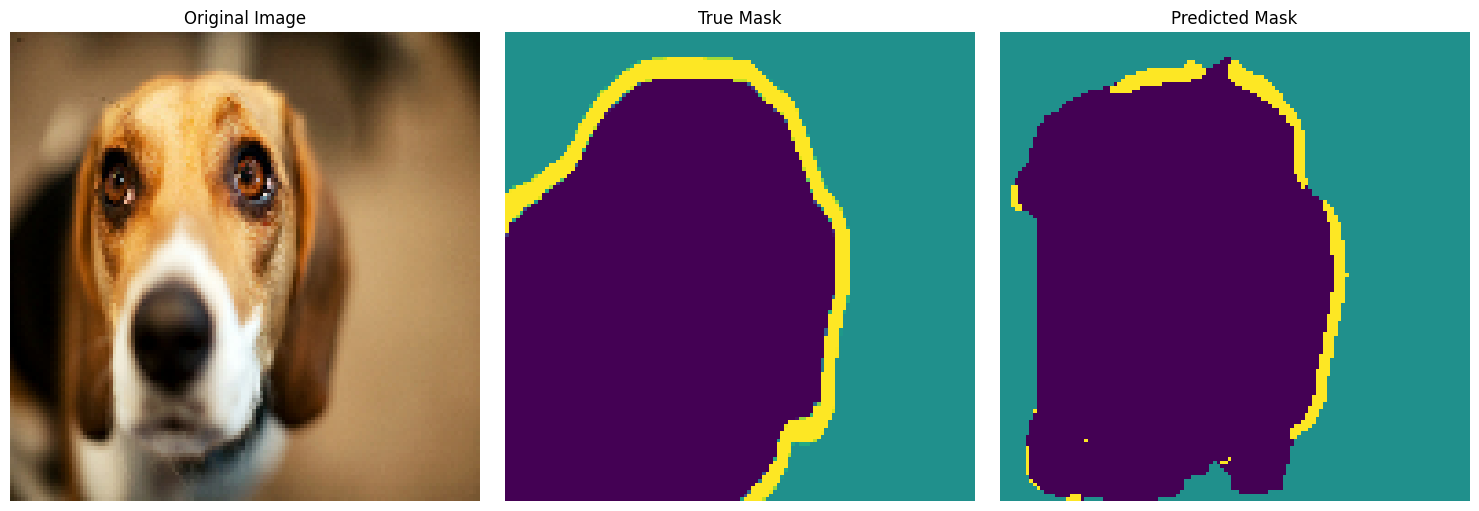

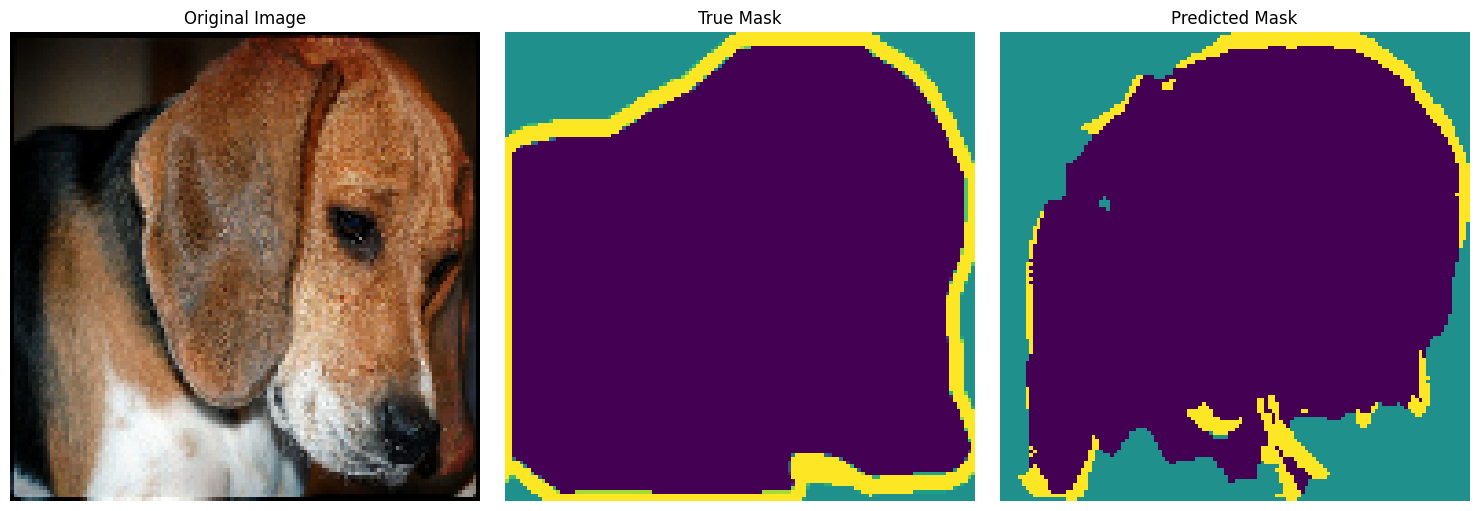

In [18]:
visualize_predictions(model_history.model, test_batches)